In [ ]:
pip install torch

   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
    --------------------------------------- 2.9/204.1 MB 16.8 MB/s eta 0:00:12
   - -------------------------------------- 7.6/204.1 MB 19.5 MB/s eta 0:00:11
   --- ------------------------------------ 16.0/204.1 MB 26.3 MB/s eta 0:00:08
   ----- ---------------------------------- 26.7/204.1 MB 33.2 MB/s eta 0:00:06
   ------- -------------------------------- 36.2/204.1 MB 35.0 MB/s eta 0:00:05
   --------- ------------------------------ 47.4/204.1 MB 37.9 MB/s eta 0:00:05
   ----------- ---------------------------- 59.0/204.1 MB 40.6 MB/s eta 0:00:04
   ------------- -------------------------- 67.4/204.1 MB 40.4 MB/s eta 0:00:04
   -------------- ------------------------- 76.3/204.1 MB 40.5 MB/s eta 0:00:04
   ---------------- ----------------------- 83.9/204.1 MB 39.7 MB/s eta 0:00:04
   ------------------ --------------------- 93.3/204.1 MB 40.1 MB/s eta 0:00:03
   ------------------- ------------------- 103.8/20


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import librosa
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfcc.T, axis=0)  # Average across time

In [17]:
X, y = [], []
for lang_idx, language in enumerate(os.listdir("dataset")):
    for file in os.listdir(f"dataset/{language}"):
        if file.endswith(".mp3"):
            features = extract_mfcc(f"dataset/{language}/{file}")
            X.append(features)
            y.append(lang_idx)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = SVC(kernel='rbf', C=10)
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.8515


USING CNN 

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import numpy as np


In [22]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfcc.T  # Shape: (time_steps, 40)

In [23]:
X, y = [], []
for lang_idx, lang in enumerate(["hindi", "kannada", "tamil", "malayalam", "marathi", 
                 "punjabi", "urdu", "bengali", "gujarati", "telugu"]):  # Your 10 languages
    for file in os.listdir(f"dataset/{lang}"):
        if file.endswith(".mp3"):
            features = extract_features(f"dataset/{lang}/{file}")
            X.append(features)
            y.append(lang_idx)


In [26]:
max_len = 100  # Adjust based on your data
X_padded = np.array([np.pad(x, ((0, max_len - x.shape[0]), (0, 0))) for x in X])
X_tensor = torch.FloatTensor(X_padded)  # Shape: (n_samples, 100, 40)
y_tensor = torch.LongTensor(y)


In [27]:
# 3. Define CNN Model
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 25, 10)  # 10 output classes

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to (batch, channels, time)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)


In [28]:
model = AudioCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(10):
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.7047
Epoch 2, Loss: 0.7295
Epoch 3, Loss: 0.3038
Epoch 4, Loss: 0.2357
Epoch 5, Loss: 0.4791
Epoch 6, Loss: 0.2457
Epoch 7, Loss: 0.1914
Epoch 8, Loss: 0.3528
Epoch 9, Loss: 0.3919
Epoch 10, Loss: 0.0490


In [30]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

In [31]:
def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

# Training loop with accuracy
for epoch in range(10):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        # Calculate batch accuracy
        acc = calculate_accuracy(batch_y, outputs)
        epoch_acc += acc
        epoch_loss += loss.item()
    
    # Print epoch stats
    avg_loss = epoch_loss / len(loader)
    avg_acc = epoch_acc / len(loader)
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={avg_acc:.2%}")

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())
    
    acc = accuracy_score(all_true, all_preds)
    print(f"\nTest Accuracy: {acc:.2%}")
    return acc

# Usage (assuming you have a test_loader)
test_accuracy = evaluate(model, test_loader)

Epoch 1: Loss=0.1146, Accuracy=96.35%
Epoch 2: Loss=0.1238, Accuracy=96.27%
Epoch 3: Loss=0.1289, Accuracy=96.23%
Epoch 4: Loss=0.0963, Accuracy=96.97%
Epoch 5: Loss=0.1396, Accuracy=96.00%
Epoch 6: Loss=0.1239, Accuracy=96.29%
Epoch 7: Loss=0.0887, Accuracy=97.12%
Epoch 8: Loss=0.0977, Accuracy=97.11%
Epoch 9: Loss=0.1022, Accuracy=96.80%
Epoch 10: Loss=0.1094, Accuracy=97.01%


NameError: name 'test_loader' is not defined

error resolve for cnn

In [ ]:
pip install
matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   --------------------------------- ------ 6.8/8.1 MB 33.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 30.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 23.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 2.6/2.6 MB 29.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [35]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfcc.T  # Shape: (time_steps, 40)

In [36]:
languages = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]

In [37]:
X, y = [], []
for lang_idx, lang in enumerate(languages):
    folder = f"dataset/{lang}"
    for file in os.listdir(folder):
        if file.endswith(".mp3"):
            features = extract_features(os.path.join(folder, file))
            X.append(features)
            y.append(lang_idx)


In [38]:
# 3. Padding
max_len = 100  # Adjust based on data
X_padded = np.array([np.pad(x, ((0, max_len - x.shape[0]), (0, 0))) for x in X])
X_tensor = torch.FloatTensor(X_padded)  # Shape: (n_samples, 100, 40)
y_tensor = torch.LongTensor(y)


In [39]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)


In [40]:
# 5. CNN Model
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 25, 10)  # Adjusted for input length of 100

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, time)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)


In [41]:
# 6. Training Setup
model = AudioCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

In [42]:
# 7. Training Loop
train_losses = []
train_accuracies = []

for epoch in range(10):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(batch_y, outputs)
        epoch_loss += loss.item()
        epoch_acc += acc

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)

    train_losses.append(avg_loss)
    train_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={avg_acc:.2%}")


Epoch 1: Loss=1.5719, Accuracy=62.00%
Epoch 2: Loss=0.5140, Accuracy=79.97%
Epoch 3: Loss=0.3613, Accuracy=85.36%
Epoch 4: Loss=0.2713, Accuracy=88.81%
Epoch 5: Loss=0.2374, Accuracy=90.62%
Epoch 6: Loss=0.1975, Accuracy=91.65%
Epoch 7: Loss=0.1692, Accuracy=93.17%
Epoch 8: Loss=0.1624, Accuracy=93.88%
Epoch 9: Loss=0.1526, Accuracy=94.01%
Epoch 10: Loss=0.1364, Accuracy=95.15%


In [43]:
torch.save(model.state_dict(), "audio_cnn_model.pth")
print("Model saved as audio_cnn_model.pth")


Model saved as audio_cnn_model.pth


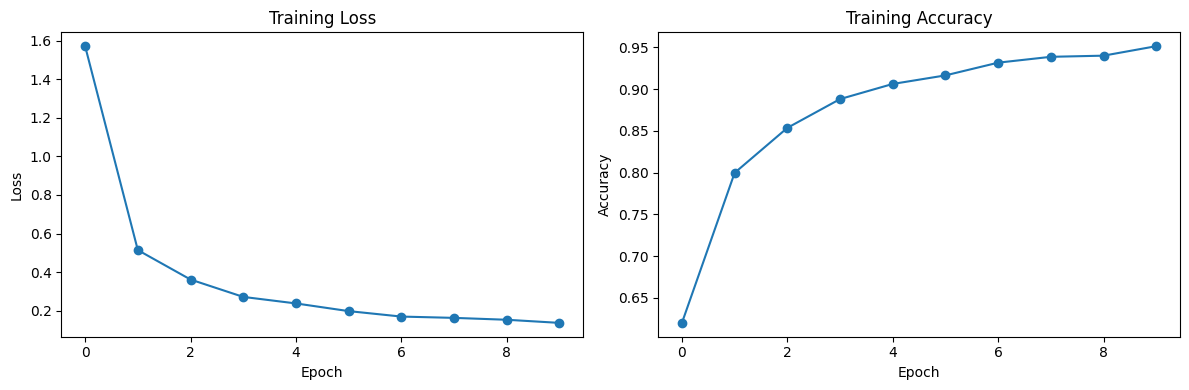

In [44]:
# 9. Plotting loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, marker='o')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [45]:
# 10. Evaluation on test set
def evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            outputs = model(batch_x)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    print(f"\nTest Accuracy: {acc:.2%}")
    return acc

test_accuracy = evaluate(model, test_loader)


Test Accuracy: 82.45%


In [46]:
def predict_language(file_path, model, class_names):
    model.eval()
    features = extract_features(file_path)  # No augment for test
    padded = np.pad(features, ((0, 100 - features.shape[0]), (0, 0)))
    tensor = torch.FloatTensor(padded).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(tensor)
        _, predicted = torch.max(output, 1)
        print(f"Predicted Language: {class_names[predicted.item()]}")


In [47]:
predict_language("test_audio.mp3", model, languages)


Predicted Language: urdu


Testing

In [48]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [52]:
import sounddevice as sd
import librosa
import torch
import numpy as np
from scipy.io.wavfile import write

# --- Your CNN Model ---
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 25, 10)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# --- Load Model ---
model = AudioCNN()
model.load_state_dict(torch.load("audio_cnn_model.pth"))
model.eval()

languages = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]

# --- Real-time Recording + Prediction ---
def predict_live_language(duration=5, sr=16000):
    print(f"\n🎙️ Recording {duration} seconds of audio...")
    recording = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
    sd.wait()
    audio = recording.flatten()

    # --- Preprocess ---
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T
    padded = np.pad(mfcc, ((0, max(0, 100 - mfcc.shape[0])), (0, 0)))
    padded = padded[:100]  # Ensure exact shape

    tensor = torch.FloatTensor(padded).unsqueeze(0)
    with torch.no_grad():
        output = model(tensor)
        _, pred = torch.max(output, 1)
        print(f"🧠 Predicted Language: {languages[pred.item()]}")

# --- Run it ---
predict_live_language()



🎙️ Recording 5 seconds of audio...
🧠 Predicted Language: telugu


Model: CNN + BiLSTM

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import librosa
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'joblib'

In [54]:
# --- 1. Feature Extraction ---
def extract_features(file_path, max_len=100):
    audio, sr = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T
    if mfcc.shape[0] < max_len:
        mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)))
    else:
        mfcc = mfcc[:max_len]
    return mfcc  # (100, 40)

In [55]:
# --- 2. Load Dataset ---
languages = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]
X, y = [], []

for idx, lang in enumerate(languages):
    for file in os.listdir(f"dataset/{lang}"):
        if file.endswith(".mp3"):
            feat = extract_features(f"dataset/{lang}/{file}")
            X.append(feat)
            y.append(idx)

X_tensor = torch.FloatTensor(X)  # (n_samples, 100, 40)
y_tensor = torch.LongTensor(y)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
train_ds, test_ds = random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


C:\Users\DATA PROWESS PVT LTD\AppData\Local\Temp\ipykernel_9224\43522526.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  X_tensor = torch.FloatTensor(X)  # (n_samples, 100, 40)


In [56]:
# --- 3. Model ---
class CNNBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 10)  # 10 languages

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 40, 100)
        x = self.pool(torch.relu(self.conv1(x)))  # (B, 64, 50)
        x = x.permute(0, 2, 1)  # (B, 50, 64)
        lstm_out, _ = self.lstm(x)  # (B, 50, 256)
        out = lstm_out[:, -1, :]  # last timestep
        return self.fc(out)

In [57]:
# --- 4. Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            acc = (outputs.argmax(1) == batch_y).float().mean().item()
            total_loss += loss.item()
            total_acc += acc
        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Accuracy={avg_acc:.2%}")

train_model()



Epoch 1: Loss=1.1584, Accuracy=60.32%
Epoch 2: Loss=0.6004, Accuracy=76.96%
Epoch 3: Loss=0.4700, Accuracy=80.10%
Epoch 4: Loss=0.3722, Accuracy=83.54%
Epoch 5: Loss=0.3335, Accuracy=85.19%
Epoch 6: Loss=0.3062, Accuracy=85.59%
Epoch 7: Loss=0.2730, Accuracy=86.48%
Epoch 8: Loss=0.2551, Accuracy=87.28%
Epoch 9: Loss=0.2325, Accuracy=88.28%
Epoch 10: Loss=0.2160, Accuracy=88.54%



✅ Test Accuracy: 84.60%


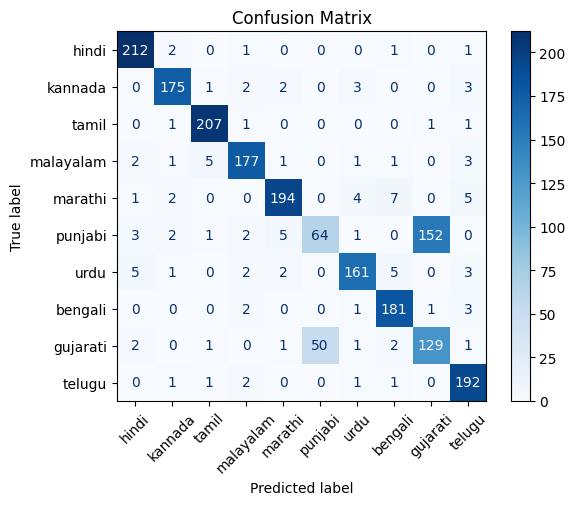

In [58]:
# --- 5. Evaluate & Confusion Matrix ---
def evaluate_and_plot():
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(batch_y.numpy())

    acc = accuracy_score(all_true, all_preds)
    print(f"\n✅ Test Accuracy: {acc:.2%}")
    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=languages)
    disp.plot(xticks_rotation=45, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_and_plot()

In [59]:
torch.save(model.state_dict(), "cnn_bilstm_langid.pth")
print("🎉 Model saved as cnn_bilstm_langid.pth")

🎉 Model saved as cnn_bilstm_langid.pth


In [63]:
import torch
import torch.nn as nn
import librosa
import numpy as np

# Load the trained model class
class CNNBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 10)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 40, 100)
        x = self.pool(torch.relu(self.conv1(x)))  # (B, 64, 50)
        x = x.permute(0, 2, 1)  # (B, 50, 64)
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

# --- Parameters ---
LANGUAGES = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]

MAX_LEN = 100  # Number of frames for padding

# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM().to(device)
model.load_state_dict(torch.load("cnn_bilstm_langid.pth", map_location=device))
model.eval()

# --- Audio Preprocessing ---
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T
    if mfcc.shape[0] < MAX_LEN:
        mfcc = np.pad(mfcc, ((0, MAX_LEN - mfcc.shape[0]), (0, 0)))
    else:
        mfcc = mfcc[:MAX_LEN]
    return torch.FloatTensor(mfcc).unsqueeze(0).to(device)  # shape: (1, 100, 40)

# --- Predict Language ---
def predict_language(audio_path):
    features = preprocess_audio(audio_path)
    with torch.no_grad():
        output = model(features)
        predicted_class = torch.argmax(output, dim=1).item()
    return LANGUAGES[predicted_class]

# --- Run on your file ---
file_path = "kan_test.mp3"  # Change this to your file
predicted_lang = predict_language(file_path)
print(f"🎙️ Detected Language: {predicted_lang.capitalize()}")


🎙️ Detected Language: Kannada


In [ ]:
import torch
import torch.nn as nn
import librosa
import numpy as np
import io
import soundfile as sf
import speech_recognition as sr

# --- Language Labels ---
LANGUAGES = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]

LANG_CODE_MAP = {
    "hindi": "hi-IN",
    "kannada": "kn-IN",
    "tamil": "ta-IN",
    "malayalam": "ml-IN",
    "marathi": "mr-IN",
    "punjabi": "pa-IN",
    "urdu": "ur-IN",
    "bengali": "bn-IN",
    "gujarati": "gu-IN",
    "telugu": "te-IN",
}

# --- CNN + BiLSTM Model Definition ---
class CNNBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128 * 2, 10)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# --- Load Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM().to(device)
model.load_state_dict(torch.load("cnn_bilstm_langid.pth", map_location=device))
model.eval()

# --- Preprocessing for Language Detection ---
def preprocess_audio(file_path, max_len=100):
    audio, sample_rate = librosa.load(file_path, sr=16000, duration=3)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T
    if mfcc.shape[0] < max_len:
        mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)))
    else:
        mfcc = mfcc[:max_len]
    return torch.FloatTensor(mfcc).unsqueeze(0).to(device), audio, sample_rate

# --- Detect Language from Audio ---
def detect_language(mp3_path):
    tensor, _, _ = preprocess_audio(mp3_path)
    with torch.no_grad():
        output = model(tensor)
        predicted = torch.argmax(output, dim=1).item()
        return LANGUAGES[predicted]

# --- Transcribe Audio to Text ---
def speech_to_text(mp3_path, lang_code='en-IN'):
    audio_data, sample_rate = librosa.load(mp3_path, sr=16000)

    # Save to in-memory WAV buffer
    buffer = io.BytesIO()
    sf.write(buffer, audio_data, sample_rate, format='WAV')
    buffer.seek(0)

    recognizer = sr.Recognizer()
    with sr.AudioFile(buffer) as source:
        audio = recognizer.record(source)
        try:
            return recognizer.recognize_google(audio, language=lang_code)
        except sr.UnknownValueError:
            return "❗ Could not understand the audio. Speak clearly"
        except sr.RequestError:
            return "❗ Google API request failed."

# --- Main Function ---
def analyze_audio(mp3_path):
    print("🔍 Detecting language...")
    lang = detect_language (mp3_path)
    print(f"🌐 Language Detected: {lang.capitalize()}")

    print("🗣️ Transcribing speech to text...")
    lang_code = LANG_CODE_MAP.get(lang.lower(), 'en-IN')
    transcription = speech_to_text(mp3_path, lang_code)
    print(f"📝 Transcribed Text: {transcription}")

# --- Run the Script ---
if __name__ == "__main__":
    mp3_file = "kan_test.mp3"
    analyze_audio(mp3_file)


🔍 Detecting language...
🌐 Language Detected: Kannada
🗣️ Transcribing speech to text...
📝 Transcribed Text: ಆದ್ದರಿಂದ ಮಾ


Video

In [83]:
pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
   --- ------------------------------------ 3.7/39.5 MB 20.2 MB/s eta 0:00:02
   -------- ------------------------------- 8.7/39.5 MB 22.0 MB/s eta 0:00:02
   -------------- ------------------------- 14.4/39.5 MB 23.4 MB/s eta 0:00:02
   ------------------- -------------------- 19.4/39.5 MB 24.5 MB/s eta 0:00:01
   ------------------------- -------------- 24.9/39.5 MB 23.8 MB/s eta 0:00:01
   ---------------------------- ----------- 28.3/39.5 MB 22.3 MB/s eta 0:00:01
   --------------------------------- ------ 33.6/39.5 MB 22.5 MB/s eta 0:00:01
   ---------------------------------------  39.1/39.5 MB 22.9 MB/s eta 0:00:01
   ---------------------------------------- 39.5/39.5 MB 21.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import librosa
import sounddevice as sd
import io
import soundfile as sf
import speech_recognition as sr
import queue
import threading
import time

# ---------------- Your Model and Language Mapping ----------------
LANGUAGES = ["hindi", "kannada", "tamil", "malayalam", "marathi",
             "punjabi", "urdu", "bengali", "gujarati", "telugu"]

LANG_CODE_MAP = {
    "hindi": "hi-IN", "kannada": "kn-IN", "tamil": "ta-IN", "malayalam": "ml-IN",
    "marathi": "mr-IN", "punjabi": "pa-IN", "urdu": "ur-IN", "bengali": "bn-IN",
    "gujarati": "gu-IN", "telugu": "te-IN"
}

class CNNBiLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(40, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBiLSTM().to(device)
model.load_state_dict(torch.load("cnn_bilstm_langid.pth", map_location=device))
model.eval()

# ---------------- Audio Streaming & Inference ----------------
audio_queue = queue.Queue()
transcription = ""
language = "english"

def detect_language(audio_np, sample_rate):
    mfcc = librosa.feature.mfcc(y=audio_np, sr=sample_rate, n_mfcc=40).T
    mfcc = np.pad(mfcc, ((0, 100 - mfcc.shape[0]), (0, 0))) if mfcc.shape[0] < 100 else mfcc[:100]
    tensor = torch.FloatTensor(mfcc).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor)
        predicted = torch.argmax(output, dim=1).item()
        return LANGUAGES[predicted]

def recognize_stream():
    global transcription, language
    while True:
        if not audio_queue.empty():
            audio_np, sr = audio_queue.get()
            try:
                lang = detect_language(audio_np, sr)
                lang_code = LANG_CODE_MAP.get(lang.lower(), "en-IN")

                buffer = io.BytesIO()
                sf.write(buffer, audio_np, sr, format='WAV')
                buffer.seek(0)

                recognizer = sr.Recognizer()
                with sr.AudioFile(buffer) as source:
                    audio = recognizer.record(source)
                    transcription = recognizer.recognize_google(audio, language=lang_code)
                    language = lang.capitalize()
            except Exception:
                transcription = "..."
        time.sleep(1)

def audio_capture(duration=3, sample_rate=16000):
    while True:
        audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
        sd.wait()
        audio_np = audio.flatten()
        audio_queue.put((audio_np, sample_rate))

# ---------------- Video + Caption Display ----------------
def start_video_captioning():
    cap = cv2.VideoCapture(0)
    font = cv2.FONT_HERSHEY_SIMPLEX

    threading.Thread(target=recognize_stream, daemon=True).start()
    threading.Thread(target=audio_capture, daemon=True).start()

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        cv2.putText(frame, f"[{language}] {transcription}", (20, 30), font, 0.7, (0, 255, 0), 2)
        cv2.imshow("Live Captioning", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# ---------------- Start ----------------
if __name__ == "__main__":
    start_video_captioning()


KeyboardInterrupt: 

: 